# Setup

Pip install `ultralytics` and [dependencies](https://github.com/ultralytics/ultralytics/blob/main/pyproject.toml) and check software and hardware.

[![PyPI - Version](https://img.shields.io/pypi/v/ultralytics?logo=pypi&logoColor=white)](https://pypi.org/project/ultralytics/) [![Downloads](https://static.pepy.tech/badge/ultralytics)](https://www.pepy.tech/projects/ultralytics) [![PyPI - Python Version](https://img.shields.io/pypi/pyversions/ultralytics?logo=python&logoColor=gold)](https://pypi.org/project/ultralytics/)

In [2]:
!git clone https://github.com/kris-himax/ultralytics
%cd ultralytics
%pip install .
%cd ..
import ultralytics
ultralytics.checks()

Ultralytics 8.3.53 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.7/112.6 GB disk)


# 0. export int8 tflite with BatchMatMul Operater

Ultralytics 8.3.53 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)
WARNING ⚠️ INT8 export requires a missing 'data' arg for calibration. Using default 'data=coco8.yaml'.
YOLO11n summary (fused): 238 layers, 2,616,248 parameters, 0 gradients, 6.5 GFLOPs

PyTorch: starting from 'yolo11n.pt' with input shape (1, 3, 192, 192) BCHW and output shape(s) (1, 84, 756) (5.4 MB)
requirements: Ultralytics requirements ['sng4onnx>=1.0.1', 'onnx_graphsurgeon>=0.3.26', 'onnx>=1.12.0', 'onnx2tf>1.17.5,<=1.22.3', 'onnxslim>=0.1.31', 'tflite_support', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.6/136.6 kB 97.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 kB 261.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 169.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 435.0/435.0 kB 127.6 MB/s eta 0:0

100%|██████████| 1.11M/1.11M [00:00<00:00, 165MB/s]
Unzipping calibration_image_sample_data_20x128x128x3_float32.npy.zip to /content/calibration_image_sample_data_20x128x128x3_float32.npy...: 100%|██████████| 1/1 [00:00<00:00, 48.41file/s]


ONNX: starting export with onnx 1.17.0 opset 19...


ONNX: slimming with onnxslim 0.1.45...
ONNX: export success ✅ 1.4s, saved as 'yolo11n.onnx' (10.1 MB)
TensorFlow SavedModel: collecting INT8 calibration images from 'data=coco8.yaml'

Dataset 'coco8.yaml' images not found ⚠️, missing path '/content/datasets/coco8/images/val'


100%|██████████| 433k/433k [00:00<00:00, 64.1MB/s]
Unzipping /content/datasets/coco8.zip to /content/datasets/coco8...: 100%|██████████| 25/25 [00:00<00:00, 3369.68file/s]

Dataset download success ✅ (1.3s), saved to /content/datasets



100%|██████████| 755k/755k [00:00<00:00, 99.6MB/s]
Scanning /content/datasets/coco8/labels/val... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<00:00, 104.53it/s]

New cache created: /content/datasets/coco8/labels/val.cache
TensorFlow SavedModel: WARNING ⚠️ >300 images recommended for INT8 calibration, found 4 images.


TensorFlow SavedModel: starting TFLite export with onnx2tf 1.22.3...
TensorFlow SavedModel: export success ✅ 96.6s, saved as 'yolo11n_saved_model' (35.1 MB)

TensorFlow Lite: starting export with tensorflow 2.17.1...
TensorFlow Lite: export success ✅ 0.0s, saved as 'yolo11n_saved_model/yolo11n_int8.tflite' (2.7 MB)

Export complete (98.3s)
Results saved to /content
Predict:         yolo predict task=detect model=yolo11n_saved_model/yolo11n_int8.tflite imgsz=192 int8 
Validate:        yolo val task=detect model=yolo11n_saved_model/yolo11n_int8.tflite imgsz=192 data=/usr/src/ultralytics/ultralytics/cfg/datasets/coco.yaml int8 
Visualize:       https://netron.app
WARNING ⚠️ Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.
WARNING ⚠️ 'source' is missing. Using 'source=/content/ultralytics/ultralytics/assets'.
Loading yolo11n_saved_model/yolo11n_full_integer_quant.tflite for Te

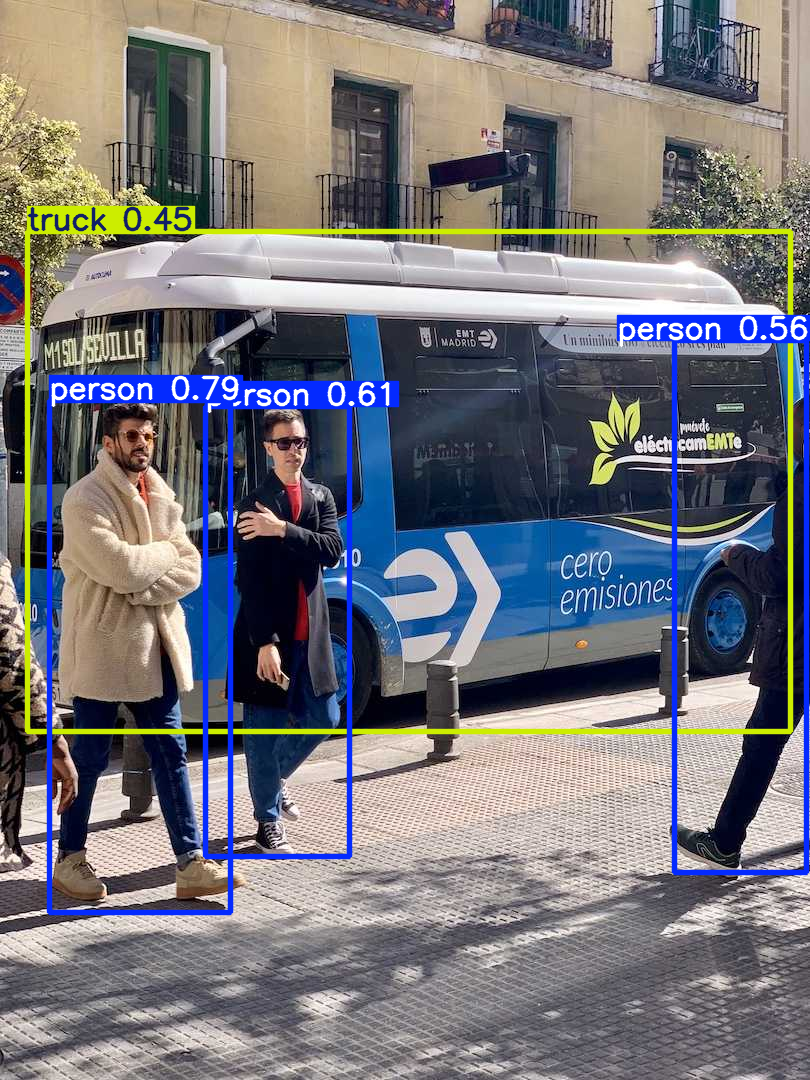

array([[[119, 146, 172],
        [121, 148, 174],
        [122, 152, 177],
        ...,
        [161, 171, 188],
        [160, 170, 187],
        [160, 170, 187]],

       [[120, 147, 173],
        [122, 149, 175],
        [123, 153, 178],
        ...,
        [161, 171, 188],
        [160, 170, 187],
        [160, 170, 187]],

       [[123, 150, 176],
        [124, 151, 177],
        [125, 155, 180],
        ...,
        [161, 171, 188],
        [160, 170, 187],
        [160, 170, 187]],

       ...,

       [[183, 182, 186],
        [179, 178, 182],
        [180, 179, 183],
        ...,
        [121, 111, 117],
        [113, 103, 109],
        [115, 105, 111]],

       [[165, 164, 168],
        [173, 172, 176],
        [187, 186, 190],
        ...,
        [102,  92,  98],
        [101,  91,  97],
        [103,  93,  99]],

       [[123, 122, 126],
        [145, 144, 148],
        [176, 175, 179],
        ...,
        [ 95,  85,  91],
        [ 96,  86,  92],
        [ 98,  88,  94]]

In [6]:
from ultralytics import YOLO
model = YOLO('yolo11n.pt')
model.export(format='tflite', imgsz=192, int8=True)
model = YOLO('yolo11n_saved_model/yolo11n_full_integer_quant.tflite')
res = model.predict(imgsz=192)
res[0].plot(show=True)

# 0.1 install vela compiler

In [7]:
!pip3 install ethos-u-vela
!wget https://raw.githubusercontent.com/HimaxWiseEyePlus/ML_FVP_EVALUATION/main/vela/himax_vela.ini

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 67.1 MB/s eta 0:00:00
--2024-12-25 02:07:53--  https://raw.githubusercontent.com/HimaxWiseEyePlus/ML_FVP_EVALUATION/main/vela/himax_vela.ini
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 889 [text/plain]
Saving to: ‘himax_vela.ini’

himax_vela.ini      100%[===================>]     889  --.-KB/s    in 0s      

2024-12-25 02:07:54 (56.5 MB/s) - ‘himax_vela.ini’ saved [889/889]



# 0.2 convert yolo11 int8 tflite to vela model

In [9]:
!vela --accelerator-config ethos-u55-64 --config himax_vela.ini --system-config My_Sys_Cfg --memory-mode My_Mem_Mode_Parent --output-dir ./ ./yolo11n_saved_model/yolo11n_full_integer_quant.tflite

 - The following shape/permutations are supported for transpose:
        When ifm rank is 2: WxC -> CxW
        When ifm rank is 3: HxWxC -> WxHxC, 1xWxC -> 1xCxW, Hx1xC -> Cx1xH
        When ifm rank is 4: 1xHxWxC -> 1xWxHxC, 1x1xWxC -> 1x1xCxW, 1xHx1xC -> 1xCx1xW
   Op has ifm_shape: [1, 4, 16, 756] and permutation is: [0 1 3 2]
 - The following shape/permutations are supported for transpose:
        When ifm rank is 2: WxC -> CxW
        When ifm rank is 3: HxWxC -> WxHxC, 1xWxC -> 1xCxW, Hx1xC -> Cx1xH
        When ifm rank is 4: 1xHxWxC -> 1xWxHxC, 1x1xWxC -> 1x1xCxW, 1xHx1xC -> 1xCx1xW
   Op has ifm_shape: [1, 24, 24, 144] and permutation is: [0 3 1 2]
 - The following shape/permutations are supported for transpose:
        When ifm rank is 2: WxC -> CxW
        When ifm rank is 3: HxWxC -> WxHxC, 1xWxC -> 1xCxW, Hx1xC -> Cx1xH
        When ifm rank is 4: 1xHxWxC -> 1xWxHxC, 1x1xWxC -> 1x1xCxW, 1xHx1xC -> 1xCx1xW
   Op has ifm_shape: [1, 128, 6, 6] and permutation is: [0 2 3 1]
I

# 1. Predict

YOLO11 may be used directly in the Command Line Interface (CLI) with a `yolo` command for a variety of tasks and modes and accepts additional arguments, i.e. `imgsz=640`. See a full list of available `yolo` [arguments](https://docs.ultralytics.com/usage/cfg/) and other details in the [YOLO11 Predict Docs](https://docs.ultralytics.com/modes/train/).


In [5]:
# Run inference on an image with YOLO11n
!yolo predict model=yolo11n.pt source='https://ultralytics.com/images/zidane.jpg'

100% 5.35M/5.35M [00:00<00:00, 321MB/s]
Ultralytics 8.3.53 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,616,248 parameters, 0 gradients, 6.5 GFLOPs

100% 49.2k/49.2k [00:00<00:00, 91.6MB/s]
image 1/1 /content/zidane.jpg: 384x640 2 persons, 1 tie, 72.7ms
Speed: 4.2ms preprocess, 72.7ms inference, 1034.8ms postprocess per image at shape (1, 3, 384, 640)
Results saved to /content/ultralytics/runs/detect/predict2
💡 Learn more at https://docs.ultralytics.com/modes/predict


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
<img align="left" src="https://user-images.githubusercontent.com/26833433/212889447-69e5bdf1-5800-4e29-835e-2ed2336dede2.jpg" width="600">

# 2. Val
Validate a model's accuracy on the [COCO](https://docs.ultralytics.com/datasets/detect/coco/) dataset's `val` or `test` splits. The latest YOLO11 [models](https://github.com/ultralytics/ultralytics#models) are downloaded automatically the first time they are used. See [YOLO11 Val Docs](https://docs.ultralytics.com/modes/val/) for more information.

In [ ]:
# Download COCO val
import torch
torch.hub.download_url_to_file('https://ultralytics.com/assets/coco2017val.zip', 'tmp.zip')  # download (780M - 5000 images)
!unzip -q tmp.zip -d datasets && rm tmp.zip  # unzip

In [ ]:
# Validate YOLO11n on COCO8 val
!yolo val model=yolo11n.pt data=coco8.yaml

Ultralytics 8.3.2 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,616,248 parameters, 0 gradients, 6.5 GFLOPs

Dataset 'coco8.yaml' images not found ⚠️, missing path '/content/datasets/coco8/images/val'
100% 433k/433k [00:00<00:00, 15.8MB/s]
Unzipping /content/datasets/coco8.zip to /content/datasets/coco8...: 100% 25/25 [00:00<00:00, 1188.35file/s]
Dataset download success ✅ (1.4s), saved to /content/datasets

100% 755k/755k [00:00<00:00, 17.7MB/s]
val: Scanning /content/datasets/coco8/labels/val... 4 images, 0 backgrounds, 0 corrupt: 100% 4/4 [00:00<00:00, 142.04it/s]
val: New cache created: /content/datasets/coco8/labels/val.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 1/1 [00:04<00:00,  4.75s/it]
                   all          4         17       0.57       0.85      0.847      0.632
                person          3         10      0.557        0.6      0.585      0.272
   

# 3. Train

<p align=""><a href="https://ultralytics.com/hub"><img width="1000" src="https://github.com/ultralytics/assets/raw/main/yolov8/banner-integrations.png"/></a></p>

Train YOLO11 on [Detect](https://docs.ultralytics.com/tasks/detect/), [Segment](https://docs.ultralytics.com/tasks/segment/), [Classify](https://docs.ultralytics.com/tasks/classify/) and [Pose](https://docs.ultralytics.com/tasks/pose/) datasets. See [YOLO11 Train Docs](https://docs.ultralytics.com/modes/train/) for more information.

In [ ]:
#@title Select YOLO11 🚀 logger {run: 'auto'}
logger = 'Comet' #@param ['Comet', 'TensorBoard']

if logger == 'Comet':
  %pip install -q comet_ml
  import comet_ml; comet_ml.init()
elif logger == 'TensorBoard':
  %load_ext tensorboard
  %tensorboard --logdir .

In [ ]:
# Train YOLO11n on COCO8 for 3 epochs
!yolo train model=yolo11n.pt data=coco8.yaml epochs=3 imgsz=640

Ultralytics 8.3.2 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=coco8.yaml, epochs=3, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width

# 4. Export

Export a YOLO11 model to any supported format below with the `format` argument, i.e. `format=onnx`. See [YOLO11 Export Docs](https://docs.ultralytics.com/modes/export/) for more information.

- 💡 ProTip: Export to [ONNX](https://docs.ultralytics.com/integrations/onnx/) or [OpenVINO](https://docs.ultralytics.com/integrations/openvino/) for up to 3x CPU speedup.  
- 💡 ProTip: Export to [TensorRT](https://docs.ultralytics.com/integrations/tensorrt/) for up to 5x GPU speedup.

| Format                                                                   | `format` Argument | Model                     | Metadata | Arguments                                                            |
|--------------------------------------------------------------------------|-------------------|---------------------------|----------|----------------------------------------------------------------------|
| [PyTorch](https://pytorch.org/)                                          | -                 | `yolo11n.pt`              | ✅        | -                                                                    |
| [TorchScript](https://docs.ultralytics.com/integrations/torchscript)     | `torchscript`     | `yolo11n.torchscript`     | ✅        | `imgsz`, `optimize`, `batch`                                         |
| [ONNX](https://docs.ultralytics.com/integrations/onnx)                   | `onnx`            | `yolo11n.onnx`            | ✅        | `imgsz`, `half`, `dynamic`, `simplify`, `opset`, `batch`             |
| [OpenVINO](https://docs.ultralytics.com/integrations/openvino)           | `openvino`        | `yolo11n_openvino_model/` | ✅        | `imgsz`, `half`, `dynamic`, `int8`, `batch`                          |
| [TensorRT](https://docs.ultralytics.com/integrations/tensorrt)           | `engine`          | `yolo11n.engine`          | ✅        | `imgsz`, `half`, `dynamic`, `simplify`, `workspace`, `int8`, `batch` |
| [CoreML](https://docs.ultralytics.com/integrations/coreml)               | `coreml`          | `yolo11n.mlpackage`       | ✅        | `imgsz`, `half`, `int8`, `nms`, `batch`                              |
| [TF SavedModel](https://docs.ultralytics.com/integrations/tf-savedmodel) | `saved_model`     | `yolo11n_saved_model/`    | ✅        | `imgsz`, `keras`, `int8`, `batch`                                    |
| [TF GraphDef](https://docs.ultralytics.com/integrations/tf-graphdef)     | `pb`              | `yolo11n.pb`              | ❌        | `imgsz`, `batch`                                                     |
| [TF Lite](https://docs.ultralytics.com/integrations/tflite)              | `tflite`          | `yolo11n.tflite`          | ✅        | `imgsz`, `half`, `int8`, `batch`                                     |
| [TF Edge TPU](https://docs.ultralytics.com/integrations/edge-tpu)        | `edgetpu`         | `yolo11n_edgetpu.tflite`  | ✅        | `imgsz`                                                              |
| [TF.js](https://docs.ultralytics.com/integrations/tfjs)                  | `tfjs`            | `yolo11n_web_model/`      | ✅        | `imgsz`, `half`, `int8`, `batch`                                     |
| [PaddlePaddle](https://docs.ultralytics.com/integrations/paddlepaddle)   | `paddle`          | `yolo11n_paddle_model/`   | ✅        | `imgsz`, `batch`                                                     |
| [MNN](https://docs.ultralytics.com/integrations/mnn)                     | `mnn`             | `yolo11n.mnn`             | ✅        | `imgsz`, `batch`, `int8`, `half`                                     |
| [NCNN](https://docs.ultralytics.com/integrations/ncnn)                   | `ncnn`            | `yolo11n_ncnn_model/`     | ✅        | `imgsz`, `half`, `batch`                                             |
| [IMX500](https://docs.ultralytics.com/integrations/sony-imx500)          | `imx`             | `yolov8n_imx_model/`      | ✅        | `imgsz`, `int8`                                                      |

In [10]:
!yolo export model=yolo11n.pt format=torchscript

Ultralytics 8.3.53 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)
YOLO11n summary (fused): 238 layers, 2,616,248 parameters, 0 gradients, 6.5 GFLOPs

PyTorch: starting from 'yolo11n.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 84, 8400) (5.4 MB)

TorchScript: starting export with torch 2.5.1+cu121...
TorchScript: export success ✅ 2.9s, saved as 'yolo11n.torchscript' (10.5 MB)

Export complete (3.8s)
Results saved to /content
Predict:         yolo predict task=detect model=yolo11n.torchscript imgsz=640  
Validate:        yolo val task=detect model=yolo11n.torchscript imgsz=640 data=/usr/src/ultralytics/ultralytics/cfg/datasets/coco.yaml  
Visualize:       https://netron.app
💡 Learn more at https://docs.ultralytics.com/modes/export


# 5. Python Usage

YOLO11 was reimagined using Python-first principles for the most seamless Python YOLO experience yet. YOLO11 models can be loaded from a trained checkpoint or created from scratch. Then methods are used to train, val, predict, and export the model. See detailed Python usage examples in the [YOLO11 Python Docs](https://docs.ultralytics.com/usage/python/).

In [ ]:
from ultralytics import YOLO

# Load a model
model = YOLO('yolo11n.yaml')  # build a new model from scratch
model = YOLO('yolo11n.pt')  # load a pretrained model (recommended for training)

# Use the model
results = model.train(data='coco8.yaml', epochs=3)  # train the model
results = model.val()  # evaluate model performance on the validation set
results = model('https://ultralytics.com/images/bus.jpg')  # predict on an image
results = model.export(format='onnx')  # export the model to ONNX format

## 1. Detection

YOLO11 _detection_ models have no suffix and are the default YOLO11 models, i.e. `yolo11n.pt` and are pretrained on COCO. See [Detection Docs](https://docs.ultralytics.com/tasks/detect/) for full details.


In [ ]:
# Load YOLO11n, train it on COCO128 for 3 epochs and predict an image with it
from ultralytics import YOLO

model = YOLO('yolo11n.pt')  # load a pretrained YOLO detection model
model.train(data='coco8.yaml', epochs=3)  # train the model
model('https://ultralytics.com/images/bus.jpg')  # predict on an image

# Appendix

Additional content below.

In [ ]:
# Pip install from source
!pip install git+https://github.com/ultralytics/ultralytics@main

In [ ]:
# Git clone and run tests on updates branch
!git clone https://github.com/ultralytics/ultralytics -b main
%pip install -qe ultralytics

In [ ]:
# Run tests (Git clone only)
!pytest ultralytics/tests

In [ ]:
# Validate multiple models
for x in 'nsmlx':
  !yolo val model=yolo11{x}.pt data=coco.yaml